<a href="https://colab.research.google.com/github/RajAakash/Transformers/blob/main/FineTuning_Sentiment_Analysis_Custom_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 2.2 MB/s eta 0:00:00


In [2]:
!pip install transformers[torch] datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.0 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import torch

from sklearn.metrics import f1_score,accuracy_score,confusion_matrix
from sklearn.model_selection import train_test_split

In [4]:
!wget -nc https://lazyprogrammer.me/course_files/AirlineTweets.csv

--2024-01-06 18:40:58--  https://lazyprogrammer.me/course_files/AirlineTweets.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3421431 (3.3M) [text/csv]
Saving to: ‘AirlineTweets.csv’

AirlineTweets.csv   100%[===================>]   3.26M  1.71MB/s    in 1.9s    

2024-01-06 18:41:02 (1.71 MB/s) - ‘AirlineTweets.csv’ saved [3421431/3421431]



In [5]:
df_=pd.read_csv('AirlineTweets.csv')

In [6]:
df_.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [7]:
df=df_[['airline_sentiment','text']].copy()

In [8]:
df.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


<Axes: >

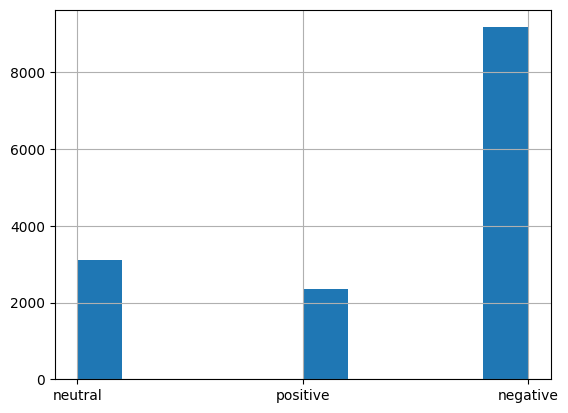

In [9]:
df['airline_sentiment'].hist()

In [10]:
target_map={'positive':1,'negative':0,'neutral':2}
df['target']=df['airline_sentiment'].map(target_map)

In [11]:
print(df['target'])

0        2
1        1
2        2
3        0
4        0
        ..
14635    1
14636    0
14637    2
14638    0
14639    2
Name: target, Length: 14640, dtype: int64


In [12]:
df2=df[['text','target']]
df2.columns=['sentence','label']
df2.to_csv('data.csv',index=None)

In [13]:
!head data.csv

sentence,label
@VirginAmerica What @dhepburn said.,2
@VirginAmerica plus you've added commercials to the experience... tacky.,1
@VirginAmerica I didn't today... Must mean I need to take another trip!,2
"@VirginAmerica it's really aggressive to blast obnoxious ""entertainment"" in your guests' faces &amp; they have little recourse",0
@VirginAmerica and it's a really big bad thing about it,0
"@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.
it's really the only bad thing about flying VA",0
"@VirginAmerica yes, nearly every time I fly VX this “ear worm” won’t go away :)",1
"@VirginAmerica Really missed a prime opportunity for Men Without Hats parody, there. https://t.co/mWpG7grEZP",2


In [14]:
from datasets import load_dataset
raw_dataset=load_dataset('csv',data_files='data.csv')

Generating train split: 0 examples [00:00, ? examples/s]

In [15]:
#if you have multiple csv files
#load_dataset('csv',data_files=['file1.csv','file2.csv'])

In [16]:
#if you alreadt have a train-test split
#load_dataset(
#    'csv',
#     data_files={'train':['train1.csv','train2.csv'],
#                  'test':'test.csv'
#   }
#)

In [17]:
raw_dataset

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 14640
    })
})

In [18]:
split=raw_dataset['train'].train_test_split(test_size=0.3,seed=42)

In [19]:
split

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 10248
    })
    test: Dataset({
        features: ['sentence', 'label'],
        num_rows: 4392
    })
})

In [20]:
checkpoint='distilbert-base-cased'

In [21]:
from transformers import AutoTokenizer

In [22]:
tokenizer=AutoTokenizer.from_pretrained(checkpoint)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [23]:
def tokenize_fn(batch):
  return tokenizer(batch['sentence'],truncation=True)

In [24]:
tokenized_datasets=split.map(tokenize_fn,batched=True)

Map:   0%|          | 0/10248 [00:00<?, ? examples/s]

Map:   0%|          | 0/4392 [00:00<?, ? examples/s]

In [45]:
from transformers import AutoModelForSequenceClassification,AutoConfig,\
  Trainer,TrainingArguments

In [47]:
config=AutoConfig.from_pretrained(checkpoint)
config

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


DistilBertConfig {
  "_name_or_path": "distilbert-base-cased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.35.2",
  "vocab_size": 28996
}

In [48]:
config.id2label

{0: 'LABEL_0', 1: 'LABEL_1'}

In [49]:
config.label2id

{'LABEL_0': 0, 'LABEL_1': 1}

In [51]:
config.id2label={v:k for k,v in target_map.items()}
config.label2id=target_map

In [52]:
model=AutoModelForSequenceClassification.from_pretrained(
    checkpoint,config=config)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'pre_classifier.bias', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [53]:
!pip install torchinfo

In [54]:
from torchinfo import summary

In [55]:
summary(model)

Layer (type:depth-idx)                                  Param #
DistilBertForSequenceClassification                     --
├─DistilBertModel: 1-1                                  --
│    └─Embeddings: 2-1                                  --
│    │    └─Embedding: 3-1                              22,268,928
│    │    └─Embedding: 3-2                              393,216
│    │    └─LayerNorm: 3-3                              1,536
│    │    └─Dropout: 3-4                                --
│    └─Transformer: 2-2                                 --
│    │    └─ModuleList: 3-5                             42,527,232
├─Linear: 1-2                                           590,592
├─Linear: 1-3                                           2,307
├─Dropout: 1-4                                          --
Total params: 65,783,811
Trainable params: 65,783,811
Non-trainable params: 0

In [56]:
training_args=TrainingArguments(
    output_dir='training_dir',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64
)

In [57]:
def compute_metrics(logits_and_labels):
  logits,labels=logits_and_labels
  predictions=np.argmax(logits,axis=-1)
  acc=np.mean(predictions==labels)
  f1=f1_score(labels,predictions,average='macro')
  return {'accuracy':acc,'f1':f1}

In [58]:
trainer=Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['test'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [59]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.542400,0.464438,0.829007,0.764930
2,0.348400,0.487464,0.834927,0.773517
3,0.252000,0.621152,0.835838,0.785188


TrainOutput(global_step=1923, training_loss=0.3316749338674719, metrics={'train_runtime': 209.7363, 'train_samples_per_second': 146.584, 'train_steps_per_second': 9.169, 'total_flos': 388879472366064.0, 'train_loss': 0.3316749338674719, 'epoch': 3.0})

In [60]:
!ls training_dir

checkpoint-1282  checkpoint-1923  checkpoint-641  runs


In [61]:
from transformers import pipeline

In [62]:
savedmodel=pipeline('text-classification',
                    model='training_dir/checkpoint-1282',
                    device=0)

In [63]:
split['test']

Dataset({
    features: ['sentence', 'label'],
    num_rows: 4392
})

In [64]:
test_pred=savedmodel(split['test']['sentence'])

In [65]:
test_pred

[{'label': 'positive', 'score': 0.9224510788917542},
 {'label': 'positive', 'score': 0.9408624172210693},
 {'label': 'positive', 'score': 0.6094777584075928},
 {'label': 'positive', 'score': 0.8037667870521545},
 {'label': 'negative', 'score': 0.6371605396270752},
 {'label': 'negative', 'score': 0.9950366616249084},
 {'label': 'neutral', 'score': 0.8870236873626709},
 {'label': 'neutral', 'score': 0.5468769073486328},
 {'label': 'positive', 'score': 0.8311787247657776},
 {'label': 'negative', 'score': 0.9971020817756653},
 {'label': 'negative', 'score': 0.9826487302780151},
 {'label': 'negative', 'score': 0.9957576394081116},
 {'label': 'positive', 'score': 0.9467450380325317},
 {'label': 'negative', 'score': 0.9930566549301147},
 {'label': 'neutral', 'score': 0.9757639765739441},
 {'label': 'neutral', 'score': 0.42742887139320374},
 {'label': 'negative', 'score': 0.8328496813774109},
 {'label': 'negative', 'score': 0.9970465302467346},
 {'label': 'negative', 'score': 0.877226591110229

In [66]:
def get_label(d):
  return int(d['label'].split('_')[1])

test_pred=[get_label(d) for d in test_pred]

IndexError: list index out of range

In [41]:
print("acc:",accuracy_score(split['test']['label'],test_pred))

acc: 0.8358378870673953


In [42]:
print("f1:",f1_score(split['test']['label'],test_pred,average='macro'))

f1: 0.7722897551093467


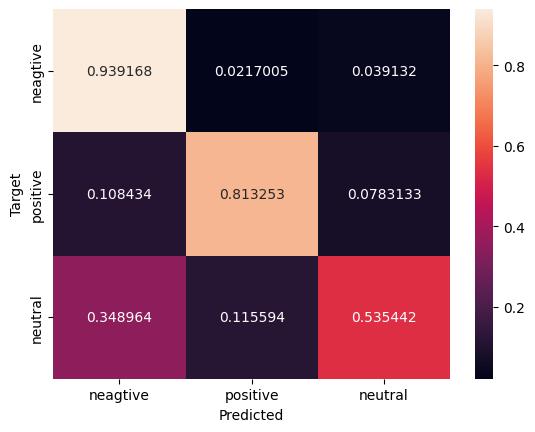

In [43]:
def plot_cm(cm):
  classes=['neagtive','positive','neutral']
  df_cm=pd.DataFrame(cm,index=classes,columns=classes)
  ax=sn.heatmap(df_cm,annot=True,fmt='g')
  ax.set_xlabel("Predicted")
  ax.set_ylabel("Target")

cm=confusion_matrix(split['test']['label'],test_pred,normalize='true')
plot_cm(cm)